In [12]:
import pandas as pd
import numpy as np
import operator 
import re

import time
import sys
import matplotlib.pyplot as plt

In [38]:
import os
import time
import re
import pickle
from datetime import datetime
import pytz
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate, Conv1D, MaxPool1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.layers import Dot, Lambda
from keras.layers import MaxPool1D, AveragePooling1D
from keras.layers import Add


from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [3]:
%%time
train = pd.read_csv("../input/train.csv").drop('target', axis=1)
test = pd.read_csv("../input/test.csv")
df = pd.concat([train ,test])

CPU times: user 1.57 s, sys: 142 ms, total: 1.71 s
Wall time: 2.41 s


In [6]:
df_split = df.question_text.apply(lambda x: x.split(' '))

In [9]:
df_len = df_split.apply(lambda x: len(x))

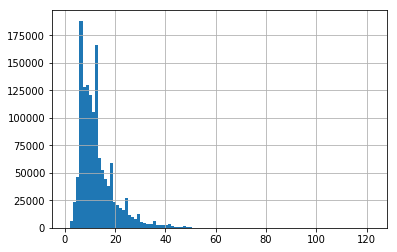

In [15]:
df_len.hist(bins=100)df_len.hist(bins=100)

In [14]:
df_len.describe()

count    1.362492e+06
mean     1.280139e+01
std      7.050398e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.500000e+01
max      1.220000e+02
Name: question_text, dtype: float64

In [37]:
np.percentile(df_len, np.linspace(0, 100, 1000))

array([  1.,   3.,   3.,   3.,   3.,   4.,   4.,   4.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
         6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
         6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
         6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
         6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
         6.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   

(50, 551)
(51, 327)
(52, 203)
(53, 121)
(54, 71)
(55, 38)
(56, 17)
(57, 12)
(58, 9)
(59, 7)
(60, 6)
(61, 6)
(62, 5)
(63, 5)
(64, 4)
(65, 3)
(66, 2)
(67, 2)
(68, 2)
(69, 2)
(70, 2)
(71, 2)
(72, 2)
(73, 2)
(74, 2)
(75, 2)
(76, 2)
(77, 2)
(78, 2)
(79, 2)


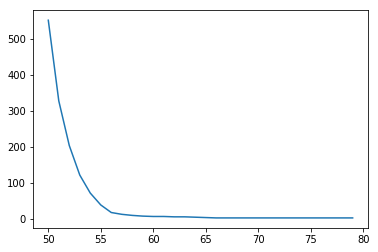

In [35]:
count_list = []
for thresh in range(50, 80):
    a = np.sum(df_len > thresh)
    print(thresh, a)
    count_list.append(a)

plt.plot(range(50, 80), count_list)

In [29]:
np.sum(df_len > 55)

38

(45, 3376)
(46, 2470)
(47, 1798)
(48, 1260)
(49, 827)
(50, 551)
(51, 327)
(52, 203)
(53, 121)
(54, 71)
(55, 38)
(56, 17)
(57, 12)
(58, 9)
(59, 7)
(60, 6)
(61, 6)
(62, 5)
(63, 5)
(64, 4)
(65, 3)
(66, 2)
(67, 2)
(68, 2)
(69, 2)
(70, 2)
(71, 2)
(72, 2)
(73, 2)
(74, 2)
(75, 2)
(76, 2)
(77, 2)
(78, 2)
(79, 2)


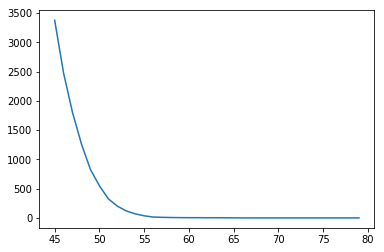

In [36]:
count_list = []
for thresh in range(45, 80):
    a = np.sum(df_len > thresh)
    print(thresh, a)
    count_list.append(a)

plt.plot(range(45, 80), count_list)

In [39]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, ' {punct} '.format(punct=punct))
    return x

def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

In [42]:
df["question_text"] = df["question_text"].str.lower()

df["question_text"] = df["question_text"].apply(lambda x: clean_text(x))
df["question_text"] = df["question_text"].apply(lambda x: clean_numbers(x))

In [43]:
df_split = df.question_text.apply(lambda x: x.split(' '))

In [44]:
df_len = df_split.apply(lambda x: len(x))

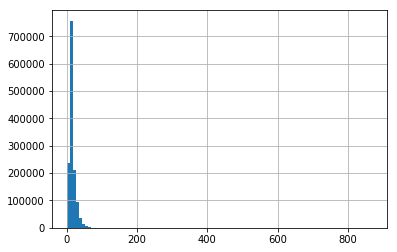

In [45]:
df_len.hist(bins=100)

In [46]:
np.percentile(df_len, np.linspace(0, 100, 1000))

array([  1.,   5.,   5.,   5.,   5.,   6.,   6.,   6.,   6.,   6.,   6.,
         6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   8.,   8.,   8.,   8.,   8.,
         8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,
         8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,
         8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,
         8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,
         8.,   8.,   8.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,
         9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,
         9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,
         9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,   9.,
         9.,   9.,   9.,   9.,   9.,   9.,   9.,   

In [56]:
np.percentile(df_len, np.linspace(0, 100, 10000))

array([  1.,   5.,   5., ...,  83.,  97., 867.])

(50, 14571)
(51, 12956)
(52, 11472)
(53, 10122)
(54, 8883)
(55, 7731)
(56, 6739)
(57, 5806)
(58, 5022)
(59, 4335)
(60, 3710)
(61, 3169)
(62, 2686)
(63, 2293)
(64, 1929)
(65, 1591)
(66, 1358)
(67, 1176)
(68, 1018)
(69, 880)
(70, 768)
(71, 685)
(72, 623)
(73, 552)
(74, 502)
(75, 451)
(76, 416)
(77, 384)
(78, 356)
(79, 331)
(80, 305)
(81, 288)
(82, 279)
(83, 269)
(84, 257)
(85, 245)
(86, 226)
(87, 215)
(88, 205)
(89, 195)
(90, 188)
(91, 178)
(92, 167)
(93, 161)
(94, 156)
(95, 150)
(96, 140)
(97, 133)
(98, 125)
(99, 120)


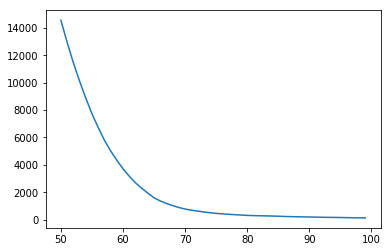

In [54]:
count_list = []
for thresh in range(50, 100):
    a = np.sum(df_len > thresh)
    print(thresh, a)
    count_list.append(a)

plt.plot(range(50, 100), count_list)

In [55]:
for a in df[df_len > 100].question_text:
    print(a)
    print('----------------------------')

what really happens in  " flapping / r - voicing "  english dialects when unstressed  / t /  or  / d /  are preceded by  / n /   ( e . g .   / nt /  and  / nd /  in  " winter ,  blender "  )  ?  is it a nasalized tap  [ ɾ̃ ]  ,   [ nɖ ]  ,   [ nɾ ]  or just  [ n ]  with the  / t ,  d /  dropping  ( winter - winner merger )  ? 
----------------------------
what is the value of  [ math ]  {  \ left (  \ cos 2x  \ right )  }  ^  { 2 }  [  \ math ]  if  [ math ]  \ sqrt [ 3 ]  {  {  \ sin x }  ^  { 2 }  }  +  \ sqrt [ 3 ]  {  {  \ cos x }  ^  { 2 }  }  =  \ sqrt [ 3 ]  { 2 }  [  \ math ]  ? 
----------------------------
why does  [ math ] 6  \ cos  \ frac  { 2 \ pi }  { 7 }   =   - 1  +   \ sqrt  [ 3 ]  {   \ frac  { 7 }  { 3 }   (  1  +  3 \ sqrt  {  - 3 }   )   }   +   \ sqrt  [ 3 ]  {   \ frac  { 7 }  { 3 }   (  1  -  3 \ sqrt  {  - 3 }   )   }   [  / math ]  still expressible in algebraic expression  ? 
----------------------------
how can i calculate the root of a number in  [ math ] 